# Ch 4. Statistical Learning

We will use a set of exploratory features in consumer cefit files and develop a credit scoring rule to predict whether the loaner will be considered a good or bad client. 

## 1. Data Preparation

This dataset is from Dr. Hans Hofmann of the University of Hamburg. (source: UCI Machine Learning Repository). 

In [175]:
# importing modules to be used 
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from __future__ import division

%matplotlib inline


In [135]:
credit = pd.read_table("Data/german.data.txt", \
                       delim_whitespace = True,
                       header = None)

colnames = ["checking_status", "duration", "credit_history", "purpose", "credit_amount",\
           "savings", "employment", "installment_rate", "personal_status", "other_parties",\
           "residence_since", "property_magnitude", "age", "other_payment_plans", "housing", \
           "existing_credits", "job", "num_dependents", "telephone", "foreign_workder", 
           "class"]

credit.columns = colnames
display(credit.head())

,checking_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_workder,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [136]:
n_records = credit.shape[0]

n_good = sum(credit['class'] == 1)
n_bad = sum(credit['class'] == 2)
greater_percent = (n_good / n_records) * 100

# Print the results
print ""
print "Total number of records: {}".format(n_records)
print "Individuals credit-worthy: {}".format(n_good)
print "Individuals not credit-worthy: {}".format(n_bad)
print "Percentage of credit-worthy clients: {:.2f}%".format(greater_percent)


Total number of records: 1000
Individuals credit-worthy: 700
Individuals not credit-worthy: 300
Percentage of credit-worthy clients: 70.00%


In [137]:
# Re-encoding outcome variable. Good : 0, Bad: 1
y = credit['class'] - 1

# Splitting data into features and target label 
X = credit.drop('class', axis = 1)

## 2. Exploratory Data Analysis
###  1) Factor variables - Cramer's V

** Cramer's V **(1946) measures the correlation between categorical variates. 

$$ V = \sqrt{\frac{\chi ^2}{n(k - 1)}} $$

where chi^2 is the statistics of Pearson;s chi-squared test of independencies, `n` is the number of samples and `k` is the number of unique classes for the two variables, whichever less. In our case, `k - 1` is equal to 1 because we have two classes in  output variable. While most of the features are categorical, we have three continuous features, duration, age, and credit amount. For the moment, we are arbitrarly categorizing these countinous features only for the sake of exploratory analysis. 

In [159]:
credit.f = X.copy()
cont = ["duration", "age", "credit_amount"]



In [139]:
# 10 break points for each cont vars
breakpoints = credit.f[cont].quantile(np.linspace(0.0, 1.0, num = 10))

for v in cont:
    credit.f[v] = pd.cut(credit.f[v], bins=breakpoints[v].unique())
    #print " "
    #print v, ": counts"
    #print pd.value_counts(credit.f[v], sort=False)


In [151]:
feature_names = list(credit.f.columns)
cramer_v = np.zeros(len(feature_names))


for i, _ in enumerate(feature_names):
    cont = pd.crosstab(credit.f.iloc[:, i], y)
    cramer_v[i] = np.sqrt(stats.chi2_contingency(cont)[0] * .001)
    
cramer_v = pd.Series(cramer_v, index = feature_names)

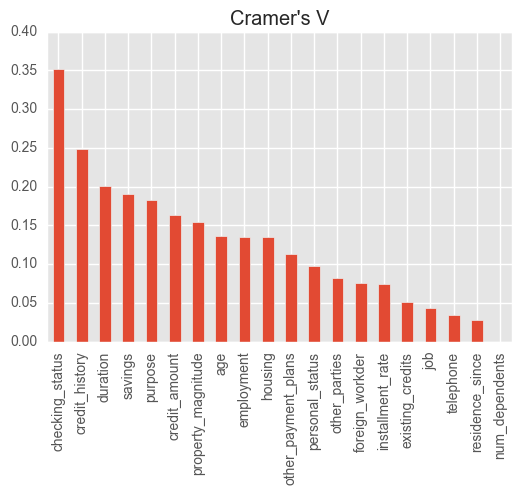

In [158]:
plt.style.use('ggplot')
cramer_v_sorted = cramer_v.sort_values(ascending = False)

plt.figure()
cramer_v_sorted.plot(kind = "bar")
plt.title("Cramer's V")


The sorted Cramer's V values for 20 features are shown above. It appears that the amount in existing checking account, credit history, and credit duration are highly associated with the ouptut label. 
  

# 3. Data Preprocessing 

## 1) Normalizaing numberical features

In [177]:
scaler = MinMaxScaler()
X[cont] = scaler.fit_transform(X[cont])
display(X[cont].describe())

,duration,age,credit_amount
count,1000.000000,1000.000000,1000.000000
mean,0.248574,0.295464,0.166241
std,0.177336,0.203133,0.155317
min,0.000000,0.000000,0.000000
25%,0.117647,0.142857,0.061379
50%,0.205882,0.250000,0.113871
75%,0.294118,0.410714,0.204812
max,1.000000,1.000000,1.000000


In [178]:
features = pd.get_dummies(X)
one_hot_encoded = list(features.columns)

print "{} total features after one-hot encoding.".format(len(one_hot_encoded))

print one_hot_encoded

61 total features after one-hot encoding.
['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents', 'checking_status_A11', 'checking_status_A12', 'checking_status_A13', 'checking_status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_A71', 'employment_A72', 'employment_A73', 'employment_A74', 'employment_A75', 'personal_status_A91', 'personal_status_A92', 'personal_status_A93', 'personal_status_A94', 'other_parties_A101', 'other_parties_A102', 'other_parties_A103', 'property_magnitude_A121', 'property_magnitude_A122', 'property_magnitude_A123', 'property_magnitude_A124', 'other_payment_plans_A141', 'other_payment_plans_A142', 'oth

## 2) Shuffle and split data


In [179]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y,\
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])



Training set has 800 samples.
Testing set has 200 samples.


# 4. Logistic Regression 

Logistic regression is now the most widely used method in credit scoring. 